### Astrobase core stuff

This notebook remixes Waqas Bhatti's `lightcurve-work.ipynb` notebook to analyze HAT's observations of Kepler 16. It uses the `hatlc`, `periodbase`, and `plotbase` modules to read in HAT light curves, run period searches, and plot the results. The `nb-data` subdirectory in the `notebooks` folder contains some sample HAT light curves to use for this work.

In [1]:
%matplotlib inline
from astrobase import hatlc, periodbase, plotbase

In [2]:
print(hatlc.read_csvlc.__doc__)


    This reads the HAT data server producd CSV light curve into a lcdict.

    lcfile is the HAT gzipped CSV LC (with a .hatlc.csv.gz extension)

    


In [3]:
print(hatlc.read_and_filter_sqlitecurve.__doc__)

This reads the sqlitecurve and optionally filters it.

    Returns columns requested in columns. If None, then returns all columns
    present in the latest columnlist in the lightcurve.

    If sqlfilters is not None, it must be a list of text sql filters that apply
    to the columns in the lightcurve.

    This returns an lcdict with an added 'lcfiltersql' key that indicates what
    the parsed SQL filter string was.

    


What is actually in the `/H/4KRED/AP/4KAP_LC/115` directory? (it's ~388k files, so ls is a bit uncooperative). Answer from quick python scripting: it's stuff that ends with: `.epdlc`, `pdlog`, `rlc`, `tfalc`, and `tmp`. So it's not the HAT produced-CSV light curve, nor is it a `sqlitecurve`. More specifically (we ssh'd these LCs over to work locally):

In [4]:
pwd

'/home/luke/Dropbox/proj/hat/src/sandbox/notebooks'

In [5]:
ls ../../../data/kepler_16/

HAT-115-0003266.epdlc   HAT-115-0003266.rlc
HAT-115-0003266.epdlog  HAT-115-0003266.tfalc


In [6]:
! head ../../../data/kepler_16/HAT-115-0003266.epdlc # notice ! lets you run shell commands directly...

# Generated by fiastrom.sh HATpipe SVN version 997
7-173419   55089.6967013 11.51299  0.00665  G 11.17438  0.00584  G 10.99055  0.00549  G  11.1914  10.8839  10.7499 11.84265 11.82917 11.82304
7-173420   55089.6994597 11.42803  0.00621  G 11.09591  0.00543  G 10.92023  0.00510  G   11.183  10.8726  10.7384 11.83379 11.82157 11.81585
7-173421   55089.7021795 11.41373  0.00621  G 11.08811  0.00546  G 10.91634  0.00514  G  11.1767  10.8592  10.7178 11.79301 11.78995 11.78795
7-173422   55089.7049574 11.57461  0.00666  G 11.26627  0.00590  G 11.10733  0.00560  G    11.16  10.8521  10.7164 11.79857 11.79302 11.79082
7-173425   55089.7129895 11.74045  0.00737  G 11.44151  0.00662  G 11.29102  0.00635  G  11.1473  10.8352  10.6956 11.82450 11.80296 11.78834
7-173426   55089.7155704 11.67144  0.00694  G 11.39150  0.00624  G 11.24490  0.00595  G  11.1218  10.8268  10.6887 11.78507 11.78107 11.77385
7-173427   55089.7183717 11.61300  0.00671  G 11.32304  0.00599  G 11.17346  0.00570  G  11.1369 

In [7]:
lcpath = '../../../data/kepler_16/HAT-115-0003266.epdlc'
lc_data, msg = hatlc.read_csvlc(lcpath)

2016-12-21T13:20:44.990867Z [INFO]: reading HATLC: ../../../data/kepler_16/HAT-115-0003266.epdlc


TypeError: a bytes-like object is required, not 'str'

# So we should add a basic "read these LCs" function to `astrobase`.

Maybe can do it directly with numpy `genfromtxt`?

In [8]:
import numpy as np

names_pre_2011 = ['SOME_ID','BJD_minus_2pt4million','MRAW0','MRAWERR0','PHOTFLAG0','MRAW1','MRAWERR1','PHOTFLAG1','MRAW2','MRAWERR2','PHOTFLAG2','MFIT0','MFIT1','MFIT2','MEPD0','MEPD1','MEPD2']
    # are these actually right?
dtype_pre_2011 = [np.string_,float,float,float,np.string_,float,float,np.string_,float,float,np.string_,float,float,float,float,float,float]
dtype_pairs = [el for el in zip(names_pre_2011, dtype_pre_2011)]
data = np.genfromtxt(lcpath, names=names_pre_2011, dtype=dtype_pairs, skip_header=1, delimiter=None)

In [9]:
data

array([ (b'', 55089.6967013, 11.51299, 0.00665, b'', 11.17438, 0.00584, b'', 10.99055, 0.00549, b'', 11.1914, 10.8839, 10.7499, 11.84265, 11.82917, 11.82304),
       (b'', 55089.6994597, 11.42803, 0.00621, b'', 11.09591, 0.00543, b'', 10.92023, 0.0051, b'', 11.183, 10.8726, 10.7384, 11.83379, 11.82157, 11.81585),
       (b'', 55089.7021795, 11.41373, 0.00621, b'', 11.08811, 0.00546, b'', 10.91634, 0.00514, b'', 11.1767, 10.8592, 10.7178, 11.79301, 11.78995, 11.78795),
       ...,
       (b'', 54723.9631491, 11.63001, 0.00621, b'', 11.29334, 0.00562, b'', 11.13792, 0.00552, b'', 11.1145, 10.82, 10.6946, 11.78935, 11.78392, 11.78324),
       (b'', 54723.9674197, 11.57288, 0.00629, b'', 11.26776, 0.00586, b'', 11.12973, 0.00586, b'', 11.0979, 10.8237, 10.7006, 11.77645, 11.7758, 11.77574),
       (b'', 54724.9126296, 11.79658, 0.00742, b'', 11.39724, 0.00654, b'', 11.18643, 0.00623, b'', 11.0989, 10.8169, 10.6942, 11.79797, 11.79198, 11.78703)], 
      dtype=[('SOME_ID', 'S'), ('BJD_minus

Reading the docs, look could be a failure to deal with variable whitespace (which is what's in the docs). Err... and more directly, it's failing to read the strings.

In [10]:
import numpy as np

names_pre_2011 = ['SOME_ID','BJD_minus_2pt4million','MRAW0','MRAWERR0','PHOTFLAG0','MRAW1','MRAWERR1','PHOTFLAG1','MRAW2','MRAWERR2','PHOTFLAG2','MFIT0','MFIT1','MFIT2','MEPD0','MEPD1','MEPD2']
    # are these actually right?
dtype_pre_2011 = ['U8',float,float,float,'U1',float,float,'U1',float,float,'U1',float,float,float,float,float,float]
dtype_pairs = [el for el in zip(names_pre_2011, dtype_pre_2011)]
data = np.genfromtxt(lcpath, names=names_pre_2011, dtype=dtype_pairs, skip_header=1, delimiter=None)
data

array([ ('7-173419', 55089.6967013, 11.51299, 0.00665, 'G', 11.17438, 0.00584, 'G', 10.99055, 0.00549, 'G', 11.1914, 10.8839, 10.7499, 11.84265, 11.82917, 11.82304),
       ('7-173420', 55089.6994597, 11.42803, 0.00621, 'G', 11.09591, 0.00543, 'G', 10.92023, 0.0051, 'G', 11.183, 10.8726, 10.7384, 11.83379, 11.82157, 11.81585),
       ('7-173421', 55089.7021795, 11.41373, 0.00621, 'G', 11.08811, 0.00546, 'G', 10.91634, 0.00514, 'G', 11.1767, 10.8592, 10.7178, 11.79301, 11.78995, 11.78795),
       ...,
       ('9-229548', 54723.9631491, 11.63001, 0.00621, 'G', 11.29334, 0.00562, 'G', 11.13792, 0.00552, 'G', 11.1145, 10.82, 10.6946, 11.78935, 11.78392, 11.78324),
       ('9-229550', 54723.9674197, 11.57288, 0.00629, 'G', 11.26776, 0.00586, 'G', 11.12973, 0.00586, 'G', 11.0979, 10.8237, 10.7006, 11.77645, 11.7758, 11.77574),
       ('9-229703', 54724.9126296, 11.79658, 0.00742, 'G', 11.39724, 0.00654, 'G', 11.18643, 0.00623, 'G', 11.0989, 10.8169, 10.6942, 11.79797, 11.79198, 11.78703)], 


So the above works and is fine. We'd need to be smarter on the dtypes depending on what `SOME_ID` actually is. However, with all these specified dtypes, numpy will do this way faster than a simple for-loop line-parser.

However, to get the general comment lenght we'll need to read at least the first ~100 lines

In [11]:
f = open(lcpath, 'rb')
flines = f.readlines()
flines[:10]

[b'# Generated by fiastrom.sh HATpipe SVN version 997\n',
 b'7-173419   55089.6967013 11.51299  0.00665  G 11.17438  0.00584  G 10.99055  0.00549  G  11.1914  10.8839  10.7499 11.84265 11.82917 11.82304\n',
 b'7-173420   55089.6994597 11.42803  0.00621  G 11.09591  0.00543  G 10.92023  0.00510  G   11.183  10.8726  10.7384 11.83379 11.82157 11.81585\n',
 b'7-173421   55089.7021795 11.41373  0.00621  G 11.08811  0.00546  G 10.91634  0.00514  G  11.1767  10.8592  10.7178 11.79301 11.78995 11.78795\n',
 b'7-173422   55089.7049574 11.57461  0.00666  G 11.26627  0.00590  G 11.10733  0.00560  G    11.16  10.8521  10.7164 11.79857 11.79302 11.79082\n',
 b'7-173425   55089.7129895 11.74045  0.00737  G 11.44151  0.00662  G 11.29102  0.00635  G  11.1473  10.8352  10.6956 11.82450 11.80296 11.78834\n',
 b'7-173426   55089.7155704 11.67144  0.00694  G 11.39150  0.00624  G 11.24490  0.00595  G  11.1218  10.8268  10.6887 11.78507 11.78107 11.77385\n',
 b'7-173427   55089.7183717 11.61300  0.00671  G

In [85]:
with open(lcfile, 'rb') as file:
    N_lines_to_check_comments = 50
    head = [next(file) for ind in range(N_lines_to_check_comments)]

# need to decode b/c it's read as a byte-literal
N_lines_with_comments = len([l for l in head if l.decode('UTF-8')[0]=='#'])

N_lines_with_comments

1

In [98]:
data.dtype.names

('SOME_ID',
 'BJD_minus_2pt4million',
 'MRAW0',
 'MRAWERR0',
 'PHOTFLAG0',
 'MRAW1',
 'MRAWERR1',
 'PHOTFLAG1',
 'MRAW2',
 'MRAWERR2',
 'PHOTFLAG2',
 'MFIT0',
 'MFIT1',
 'MFIT2',
 'MEPD0',
 'MEPD1',
 'MEPD2')

In [101]:
len(data.dtype.names)

17

In [102]:
data.dtype.names[3]

'MRAWERR0'

In [112]:
out = {}
for ix in range(len(data.dtype.names)):
    out[data.dtype.names[ix]] = data[data.dtype.names[ix]]

In [113]:
out

{'BJD_minus_2pt4million': array([ 55089.6967013,  55089.6994597,  55089.7021795, ...,  54723.9631491,
         54723.9674197,  54724.9126296]),
 'MEPD0': array([ 11.84265,  11.83379,  11.79301, ...,  11.78935,  11.77645,
         11.79797]),
 'MEPD1': array([ 11.82917,  11.82157,  11.78995, ...,  11.78392,  11.7758 ,
         11.79198]),
 'MEPD2': array([ 11.82304,  11.81585,  11.78795, ...,  11.78324,  11.77574,
         11.78703]),
 'MFIT0': array([ 11.1914,  11.183 ,  11.1767, ...,  11.1145,  11.0979,  11.0989]),
 'MFIT1': array([ 10.8839,  10.8726,  10.8592, ...,  10.82  ,  10.8237,  10.8169]),
 'MFIT2': array([ 10.7499,  10.7384,  10.7178, ...,  10.6946,  10.7006,  10.6942]),
 'MRAW0': array([ 11.51299,  11.42803,  11.41373, ...,  11.63001,  11.57288,
         11.79658]),
 'MRAW1': array([ 11.17438,  11.09591,  11.08811, ...,  11.29334,  11.26776,
         11.39724]),
 'MRAW2': array([ 10.99055,  10.92023,  10.91634, ...,  11.13792,  11.12973,
         11.18643]),
 'MRAWERR0': arr

In [117]:
first_date = head[2].decode('UTF-8')

In [122]:
first_date_filtered_line = list(filter(None, head[N_lines_with_comments].decode('UTF-8').split(' ')))

In [123]:
first_date_filtered_line

['7-173419',
 '55089.6967013',
 '11.51299',
 '0.00665',
 'G',
 '11.17438',
 '0.00584',
 'G',
 '10.99055',
 '0.00549',
 'G',
 '11.1914',
 '10.8839',
 '10.7499',
 '11.84265',
 '11.82917',
 '11.82304\n']

In [124]:
    first_date = float(first_date_filtered_line[1]) # assumes column 1 is always BJDc... perhaps wrong in >~2011 data?


In [126]:
first_date

55089.6967013

In [127]:
jan_1_2012 = 2455927

first_date+2.4e6 < jan_1_2012

True

In [134]:
foo = ['SOME_ID','BJD_minus_2pt4million','MRAW0','MRAWERR0','PHOTFLAG0','MRAW1','MRAWERR1','PHOTFLAG1','MRAW2','MRAWERR2','PHOTFLAG2','MFIT0','MFIT1','MFIT2','MEPD0','MEPD1','MEPD2']
len(foo)

17

In [3]:
def read_text_lc(lcpath):
    '''
    Read .epd, .tfalc, and .rlc light curves and return a corresponding 
    labelled dict (if <2012) or astropy table (if >=2012).
    
    Input:
    lcpath: path (string) to light curve data, which is a textfile with HAT 
    LC data.
    
    Example:
    dat = read_text_lc('HAT-115-0003266.epdlc')
    '''

    #LOGINFO('reading HATLC: {:s}'.format(lcpath))

    N_lines_to_parse_comments = 50
    with open(lcpath, 'rb') as file:
        head = [next(file) for ind in range(N_lines_to_parse_comments)]

    # decode necessary b/c read as a byte-literal
    N_comment_lines = len([l for l in head if l.decode('UTF-8')[0]=='#'])
    assert N_comment_lines < N_lines_to_parse_comments, \
        'LC file has too many comment lines'

    first_data_line = list(filter(None, \
        head[N_comment_lines].decode('UTF-8').split(' ')))
    N_cols = len(first_data_line)

    # There are different col_names depending on when HAT pipeline was run
    pre_2012_format = True if N_cols == 17 else False

    if pre_2012_format:
        #LOGINFO('Using 17 column names (format appropriate for data)')

        # TODO: are these correctly labelled (fiastrom.sh source needed)? Is ID always 8 chars?
        col_names = ['SOME_ID','BJDc','MRAW0','MRAWERR0','PHOTFLAG0','MRAW1',
            'MRAWERR1','PHOTFLAG1','MRAW2','MRAWERR2','PHOTFLAG2','MFIT0',
            'MFIT1','MFIT2','MEPD0','MEPD1','MEPD2']
        col_dtypes = ['U8',float,float,float,'U1',float,float,'U1',float,float,
            'U1',float,float,float,float,float,float]
        dtype_pairs = [el for el in zip(col_names, col_dtypes)]
        data = np.genfromtxt(lcpath, names=col_names, dtype=col_dtypes,
            skip_header=N_comment_lines, delimiter=None)
        out = {}
        for ix in range(len(data.dtype.names)):
            out[data.dtype.names[ix]] = data[data.dtype.names[ix]]

    if not pre_2012_format:
        #LOGINFO('Date after ~2012, using appropriate cols')

        # TODO: are these correctly labelled? Is KEY always 26 chars?
        col_names = ['KEY', 'SOME_ID', 'OFIELD', 'BJDc', 'MRAW0', 'MRAWERR0', 'PHOTFLAG0',
            'MRAW1', 'MRAWERR1', 'PHOTFLAG1', 'MRAW2', 'MRAWERR2', 
            'PHOTFLAG2', 'MFIT0', 'MFIT1', 'MFIT2', 'MEPD0', 'MEPD1',
            'MEPD2', 'MTFA0', 'MTFA1', 'MTFA2', 'X', 'Y', 'BG',
            'BGERR', 'S', 'D', 'K', 'HA', 'Z', 'JDc']
    
        out = ascii.read(lcpath, names=col_names, comment='#')

    
    return out


# Tests: should read HAT LCs

In [4]:
import numpy as np
from astropy.io import ascii
dat = read_text_lc('/home/luke/Dropbox/proj/hat/data/kepler_16/HAT-115-0003266.epdlc')

In [5]:
dat

{'BJDc': array([ 55089.6967013,  55089.6994597,  55089.7021795, ...,  54723.9631491,
         54723.9674197,  54724.9126296]),
 'MEPD0': array([ 11.84265,  11.83379,  11.79301, ...,  11.78935,  11.77645,
         11.79797]),
 'MEPD1': array([ 11.82917,  11.82157,  11.78995, ...,  11.78392,  11.7758 ,
         11.79198]),
 'MEPD2': array([ 11.82304,  11.81585,  11.78795, ...,  11.78324,  11.77574,
         11.78703]),
 'MFIT0': array([ 11.1914,  11.183 ,  11.1767, ...,  11.1145,  11.0979,  11.0989]),
 'MFIT1': array([ 10.8839,  10.8726,  10.8592, ...,  10.82  ,  10.8237,  10.8169]),
 'MFIT2': array([ 10.7499,  10.7384,  10.7178, ...,  10.6946,  10.7006,  10.6942]),
 'MRAW0': array([ 11.51299,  11.42803,  11.41373, ...,  11.63001,  11.57288,
         11.79658]),
 'MRAW1': array([ 11.17438,  11.09591,  11.08811, ...,  11.29334,  11.26776,
         11.39724]),
 'MRAW2': array([ 10.99055,  10.92023,  10.91634, ...,  11.13792,  11.12973,
         11.18643]),
 'MRAWERR0': array([ 0.00665,  0.

In [6]:
dat = read_text_lc('/home/luke/Dropbox/proj/hat/data/field_257/HAT-257-0000009.epdlc')

In [8]:
dat[:5]

<Table length=5>
      KEY        SOME_ID   OFIELD ...    HA       Z          JDc     
     str15        str10    int64  ... float64  float64     float64   
--------------- ---------- ------ ... -------- -------- -------------
HAT-257-0000009 6-402865_1    257 ... -3.13604 42.54386 56126.9574701
HAT-257-0000009 6-402866_1    257 ... -3.07544 41.77091  56126.959977
HAT-257-0000009 6-402867_1    257 ... -3.01652 41.02001 56126.9624272
HAT-257-0000009 6-402869_1    257 ... -2.93624 39.99488 56126.9657596
HAT-257-0000009 6-402870_1    257 ... -2.87726 39.24347 56126.9682157

## Reading HAT light curves

In [129]:
col_names = ['KEY', 'OFIELD', 'BJDc', 'MRAW0', 'MRAWERR0', 'PHOTFLAG0',
             'MRAW1', 'MRAWERR1', 'PHOTFLAG1', 'MRAW2', 'MRAWERR2', 'PHOTFLAG2',
             'MFIT0', 'MFIT1', 'MFIT2', 'MEPD0', 'MEPD1', 'MEPD2', 'MTFA0', 'MTFA1',
             'MTFA2', 'X', 'Y', 'BG', 'BGERR', 'S', 'D', 'K', 'HA', 'Z', 'JDc']
col_dtypes = ['U26',int,float,float,float,'U1',float,float,'U1',float,float,'U1']
while len(col_dtypes)<len(col_names):
    col_dtypes.append(float)

In [132]:
len(col_dtypes)

31

In [133]:
len(col_names)

31

In [2]:
ls nb-data

HAT-772-0554686-V0-DR0-hatlc.sqlite.gz  HAT-777-0058978-V0-DR0-hatlc.sqlite.gz


In [3]:
# the hatlc module read_and_filter_sqlitecurve function is used to read these
# this returns a dict with the light curve columns and info and a message indicating status of the LC read operation
lcd, msg = hatlc.read_and_filter_sqlitecurve('nb-data/HAT-772-0554686-V0-DR0-hatlc.sqlite.gz')

2016-12-20T18:24:15.437063Z [INFO]: retrieving all latest columns
2016-12-20T18:24:15.437228Z [INFO]: no LC filters specified


In [4]:
# we can get a description of the light curve using the hatlc.describe function
hatlc.describe(lcd)

OBJECT
------

objectid = HAT-772-0554686
hatid = HAT-772-0554686; twomassid = 14374811-5648595
network = HS; stations = HS02,HS04,HS06; ndet = 11261

ra = 219.450491; decl = -56.816551
pmra = 3.6; pmra_err = 2.9
pmdecl = -6.2; pmdecl_err = 2.9

jmag = 13.303; hmag = 12.65; kmag = 12.461; bmag = 17.744; vmag = 16.083
sdssg = 16.867; sdssr = 15.648; sdssi = 14.909

METADATA
--------

datarelease = 0; lcversion = 0
lastupdated = 1479866909.288; lcserver = 5b81c8c
comment = initial HS lightcurve creation
lcbestaperture = {"ism": ["002"], "ap": ["002"]}
lcsortcol = rjd
lcfiltersql = 
lcnormcols = 

CAMFILTERS
----------

7 - r - Sloan r AST0285
15 - r - Sloan r SN073 AST0285
23 - r - Sloan r SN081 AST0285

PHOTAPERTURES
-------------

000 - 2.05 px
001 - 3.00 px
002 - 4.00 px

LIGHT CURVE COLUMNS
-------------------

000 - rjd - time of observation in Reduced Julian date (JD = 2400000.0 + RJD)
001 - bjd - time of observation in Baryocentric Julian date (note: this is BJD_TDB)
002 - net - n

In [6]:
# the columns are all numpy arrays
lcd['rjd']

array([ 56092.6405579,  56092.6463396,  56140.5295653, ...,  56920.4836559,
        56920.8740464,  56921.4836334])

## Running period finding operations

In [5]:
# first, we normalize the light curve, i.e. make sure all observations are at the same zero-point.
# this is usually required for very long time-base HATNet light curves since these include different instrument
# combinations over the decade of survey operations.
normlcd = hatlc.normalize_lcdict(lcd)

/home/luke/Dropbox/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/luke/Dropbox/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [6]:
# next, break out the columns we'll use for the period-finding
# we'll use reduced JD as the times, 
# EPD magnitude in the smallest aperture as the mags, 
# and magnitude errors in the smallest aperture as the errs
times, mags, errs = normlcd['rjd'], normlcd['aep_000'], normlcd['aie_000']

In [7]:
# let's run Lomb-Scargle
glsp = periodbase.pgen_lsp(times,mags,errs)

2016-12-20T18:32:47.744121Z [INFO]: sigclip = 10.0: before = 11261 observations, after = 10979 observations
2016-12-20T18:32:47.745231Z [INFO]: using autofreq with 41438 frequency points, start P = 0.100, end P = 828.843
2016-12-20T18:32:47.745278Z [INFO]: using 16 workers...


In [8]:
# let's make a checkplot to see the periods associated with the best spectrogram peaks
# this also gives a quick overview of the object information and gets a finder chart from NASA's SkyView service
cp = plotbase.make_checkplot(glsp, times, mags, errs, objectinfo=normlcd['objectinfo'])

2016-12-20T18:33:25.744894Z [INFO]: adding in object information and finder chart for HAT-772-0554686 at RA: 219.450, DEC: -56.817


/home/luke/Dropbox/miniconda3/envs/sci/lib/python3.5/site-packages/astroquery/utils/commons.py:187: UserWarning: Coordinate string is being interpreted as an ICRS coordinate.
  warnings.warn("Coordinate string is being interpreted as an "


2016-12-20T18:33:29.177005Z [INFO]: sigclip = 4.0: before = 11261 observations, after = 10565 observations
2016-12-20T18:33:29.230283Z [INFO]: sigclip = 30.0: before = 10565 observations, after = 10565 observations
2016-12-20T18:33:29.238613Z [INFO]: spline fit done. nknots = 100,  chisq = 26606.49762, reduced chisq = 2.54267
2016-12-20T18:33:29.238704Z [INFO]: plotting phased LC with period 1.542895, epoch 56834.86481
2016-12-20T18:33:30.480610Z [INFO]: plotting phased LC with period 0.771447, epoch 56834.86481
2016-12-20T18:33:31.804432Z [INFO]: plotting phased LC with period 3.085790, epoch 56834.86481
2016-12-20T18:33:33.010641Z [INFO]: plotting phased LC with period 0.771447, epoch 56834.86481
2016-12-20T18:33:34.210123Z [INFO]: plotting phased LC with period 0.514234, epoch 56834.86481
2016-12-20T18:33:35.421112Z [INFO]: plotting phased LC with period 3.085790, epoch 56834.86481
2016-12-20T18:33:36.711029Z [INFO]: plotting phased LC with period 0.385473, epoch 56834.86481


/home/luke/Dropbox/miniconda3/envs/sci/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


2016-12-20T18:33:41.998971Z [INFO]: checkplot done -> checkplot.png


In [9]:
# to see the checkplot, let's use ipython's built in image viewer
from IPython.display import Image

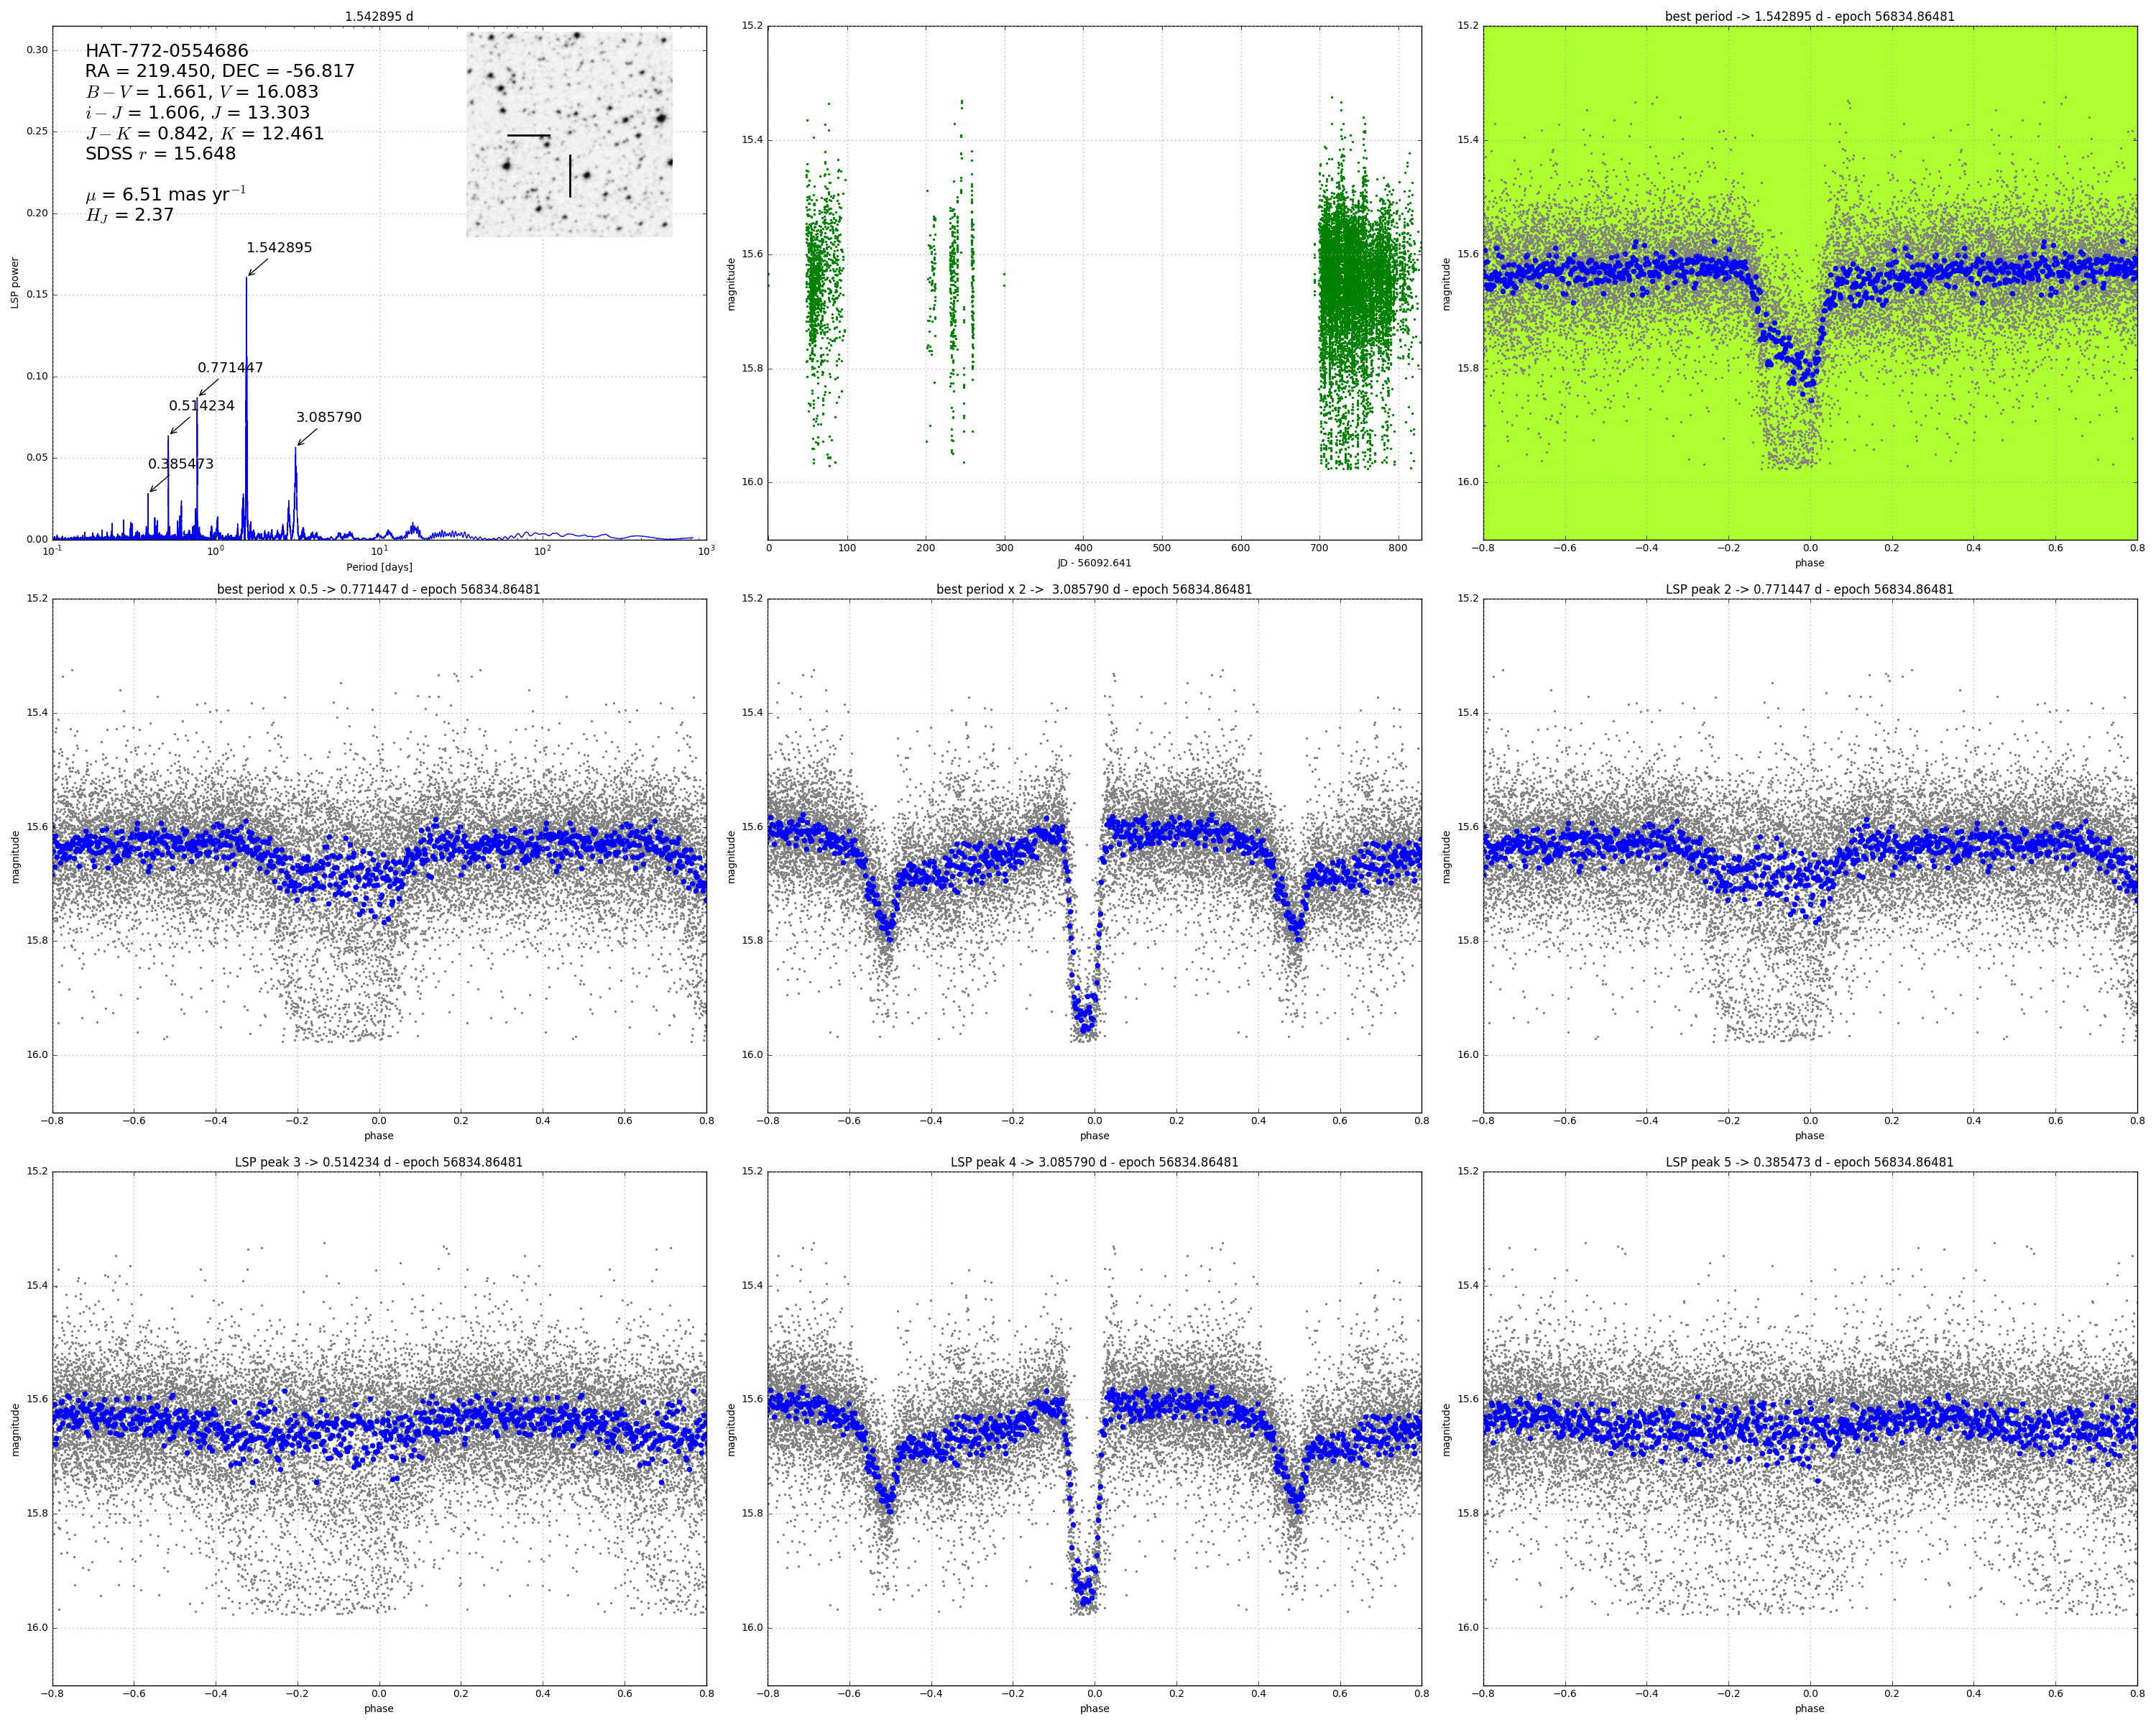

In [10]:
Image('checkplot.png')

In [11]:
# the Generalized Lomb-Scargle usually gets the period wrong for eclipsing binaries as this object appears to be
# let's try the Stellingwerf Phase-Dispersion Minimization method instead
spdm = periodbase.stellingwerf_pdm(times,mags,errs)

2016-12-20T18:35:54.238615Z [INFO]: sigclip = 10.0: before = 11261 observations, after = 10979 observations
2016-12-20T18:35:54.239530Z [INFO]: using autofreq with 41438 frequency points, start P = 0.100, end P = 828.843
2016-12-20T18:35:54.239559Z [INFO]: using 16 workers...


2016-12-20T18:36:29.407839Z [INFO]: adding in object information and finder chart for HAT-772-0554686 at RA: 219.450, DEC: -56.817


/home/luke/Dropbox/miniconda3/envs/sci/lib/python3.5/site-packages/astroquery/utils/commons.py:187: UserWarning: Coordinate string is being interpreted as an ICRS coordinate.
  warnings.warn("Coordinate string is being interpreted as an "


2016-12-20T18:36:30.148937Z [INFO]: sigclip = 4.0: before = 11261 observations, after = 10565 observations
2016-12-20T18:36:30.201502Z [INFO]: sigclip = 30.0: before = 10565 observations, after = 10565 observations
2016-12-20T18:36:30.207001Z [INFO]: spline fit done. nknots = 100,  chisq = 20324.08310, reduced chisq = 1.94229
2016-12-20T18:36:30.207086Z [INFO]: plotting phased LC with period 3.085790, epoch 56856.38349
2016-12-20T18:36:31.396222Z [INFO]: plotting phased LC with period 1.542895, epoch 56856.38349
2016-12-20T18:36:32.650130Z [INFO]: plotting phased LC with period 6.171579, epoch 56856.38349
2016-12-20T18:36:33.903435Z [INFO]: plotting phased LC with period 1.542895, epoch 56856.38349
2016-12-20T18:36:35.226044Z [INFO]: plotting phased LC with period 6.157824, epoch 56856.38349
2016-12-20T18:36:36.417045Z [INFO]: plotting phased LC with period 4.630408, epoch 56856.38349
2016-12-20T18:36:37.606598Z [INFO]: plotting phased LC with period 7.717347, epoch 56856.38349


/home/luke/Dropbox/miniconda3/envs/sci/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


2016-12-20T18:36:42.489264Z [INFO]: checkplot done -> checkplot.png


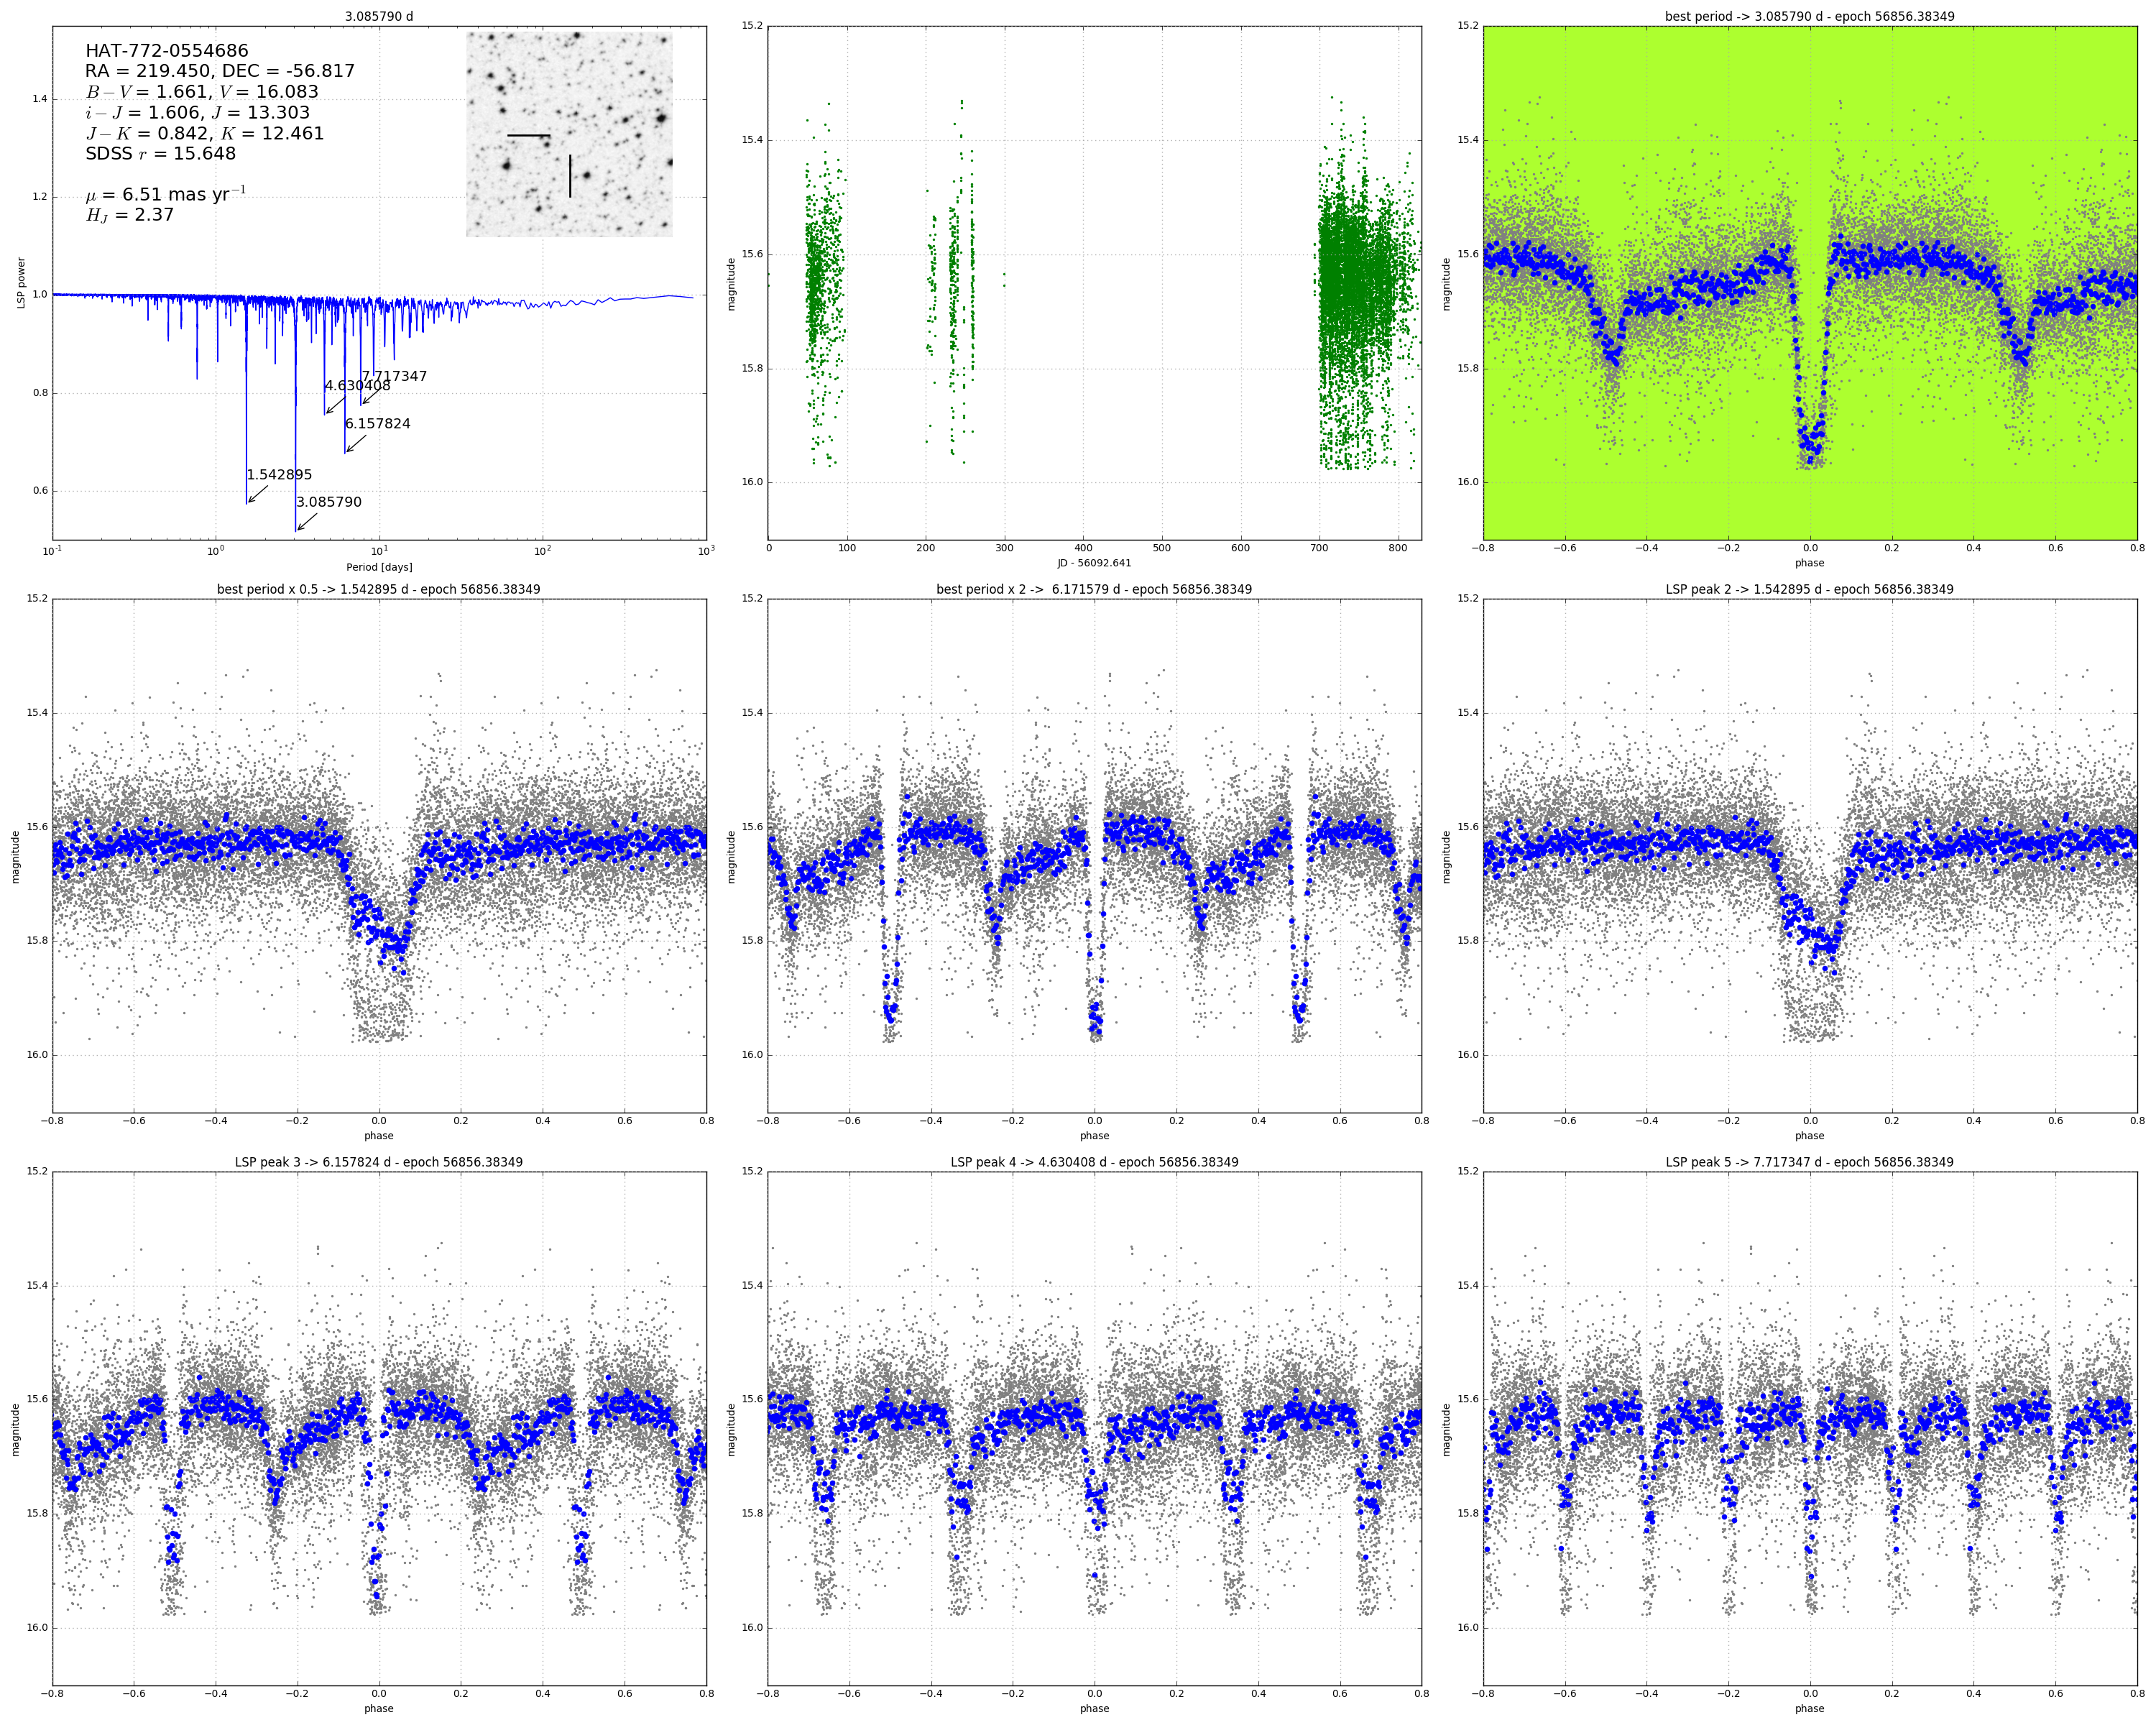

In [12]:
# make the checkplot again
cp = plotbase.make_checkplot(spdm, times, mags, errs, objectinfo=normlcd['objectinfo'])
Image('checkplot.png')

In [13]:
# that looks OK. let's check using the Box-Least-Squares fitting algorithm by Kovacs et al. (2002)
# let's set the start period to 1.0 days to cut down on the computation we have to do on this poor 4-core machine
blsp = periodbase.bls_parallel_pfind(times,mags,errs,startp=1.0)

2016-12-20T18:37:57.482155Z [INFO]: sigclip = 10.0: before = 11261 observations, after = 10979 observations
2016-12-20T18:37:57.482320Z [INFO]: autofreq: using stepsize: 3.01625250171e-06, min P: 1.0, max P: 100.0, nfreq: 328222, nphasebins: 200, min transit duration: 0.01, max transit duration: 0.8
2016-12-20T18:37:57.482362Z [INFO]: autofreq: minfreq: 0.01, maxfreq: 1.0
2016-12-20T18:37:57.482392Z [INFO]: using 16 workers...
2016-12-20T18:37:57.485047Z [INFO]: worker 1: minfreq = 0.010, nfreqs = 20514
2016-12-20T18:37:57.485098Z [INFO]: worker 2: minfreq = 0.072, nfreqs = 20514
2016-12-20T18:37:57.485128Z [INFO]: worker 3: minfreq = 0.134, nfreqs = 20514
2016-12-20T18:37:57.485157Z [INFO]: worker 4: minfreq = 0.196, nfreqs = 20514
2016-12-20T18:37:57.485186Z [INFO]: worker 5: minfreq = 0.258, nfreqs = 20514
2016-12-20T18:37:57.485216Z [INFO]: worker 6: minfreq = 0.319, nfreqs = 20514
2016-12-20T18:37:57.485244Z [INFO]: worker 7: minfreq = 0.381, nfreqs = 20514
2016-12-20T18:37:57.485

2016-12-20T18:38:17.303782Z [INFO]: adding in object information and finder chart for HAT-772-0554686 at RA: 219.450, DEC: -56.817


/home/luke/Dropbox/miniconda3/envs/sci/lib/python3.5/site-packages/astroquery/utils/commons.py:187: UserWarning: Coordinate string is being interpreted as an ICRS coordinate.
  warnings.warn("Coordinate string is being interpreted as an "


2016-12-20T18:38:17.955606Z [INFO]: sigclip = 4.0: before = 11261 observations, after = 10565 observations
2016-12-20T18:38:18.010861Z [INFO]: sigclip = 30.0: before = 10565 observations, after = 10565 observations
2016-12-20T18:38:18.017049Z [INFO]: spline fit done. nknots = 100,  chisq = 19541.65218, reduced chisq = 1.86751
2016-12-20T18:38:18.017203Z [INFO]: plotting phased LC with period 3.085607, epoch 56794.66055
2016-12-20T18:38:19.426561Z [INFO]: plotting phased LC with period 1.542803, epoch 56794.66055
2016-12-20T18:38:20.668390Z [INFO]: plotting phased LC with period 6.171213, epoch 56794.66055
2016-12-20T18:38:21.857044Z [INFO]: plotting phased LC with period 1.542756, epoch 56794.66055
2016-12-20T18:38:23.044478Z [INFO]: plotting phased LC with period 6.171077, epoch 56794.66055
2016-12-20T18:38:24.354659Z [INFO]: plotting phased LC with period 9.256583, epoch 56794.66055
2016-12-20T18:38:25.538725Z [INFO]: plotting phased LC with period 4.628186, epoch 56794.66055


/home/luke/Dropbox/miniconda3/envs/sci/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


2016-12-20T18:38:30.481767Z [INFO]: checkplot done -> checkplot.png


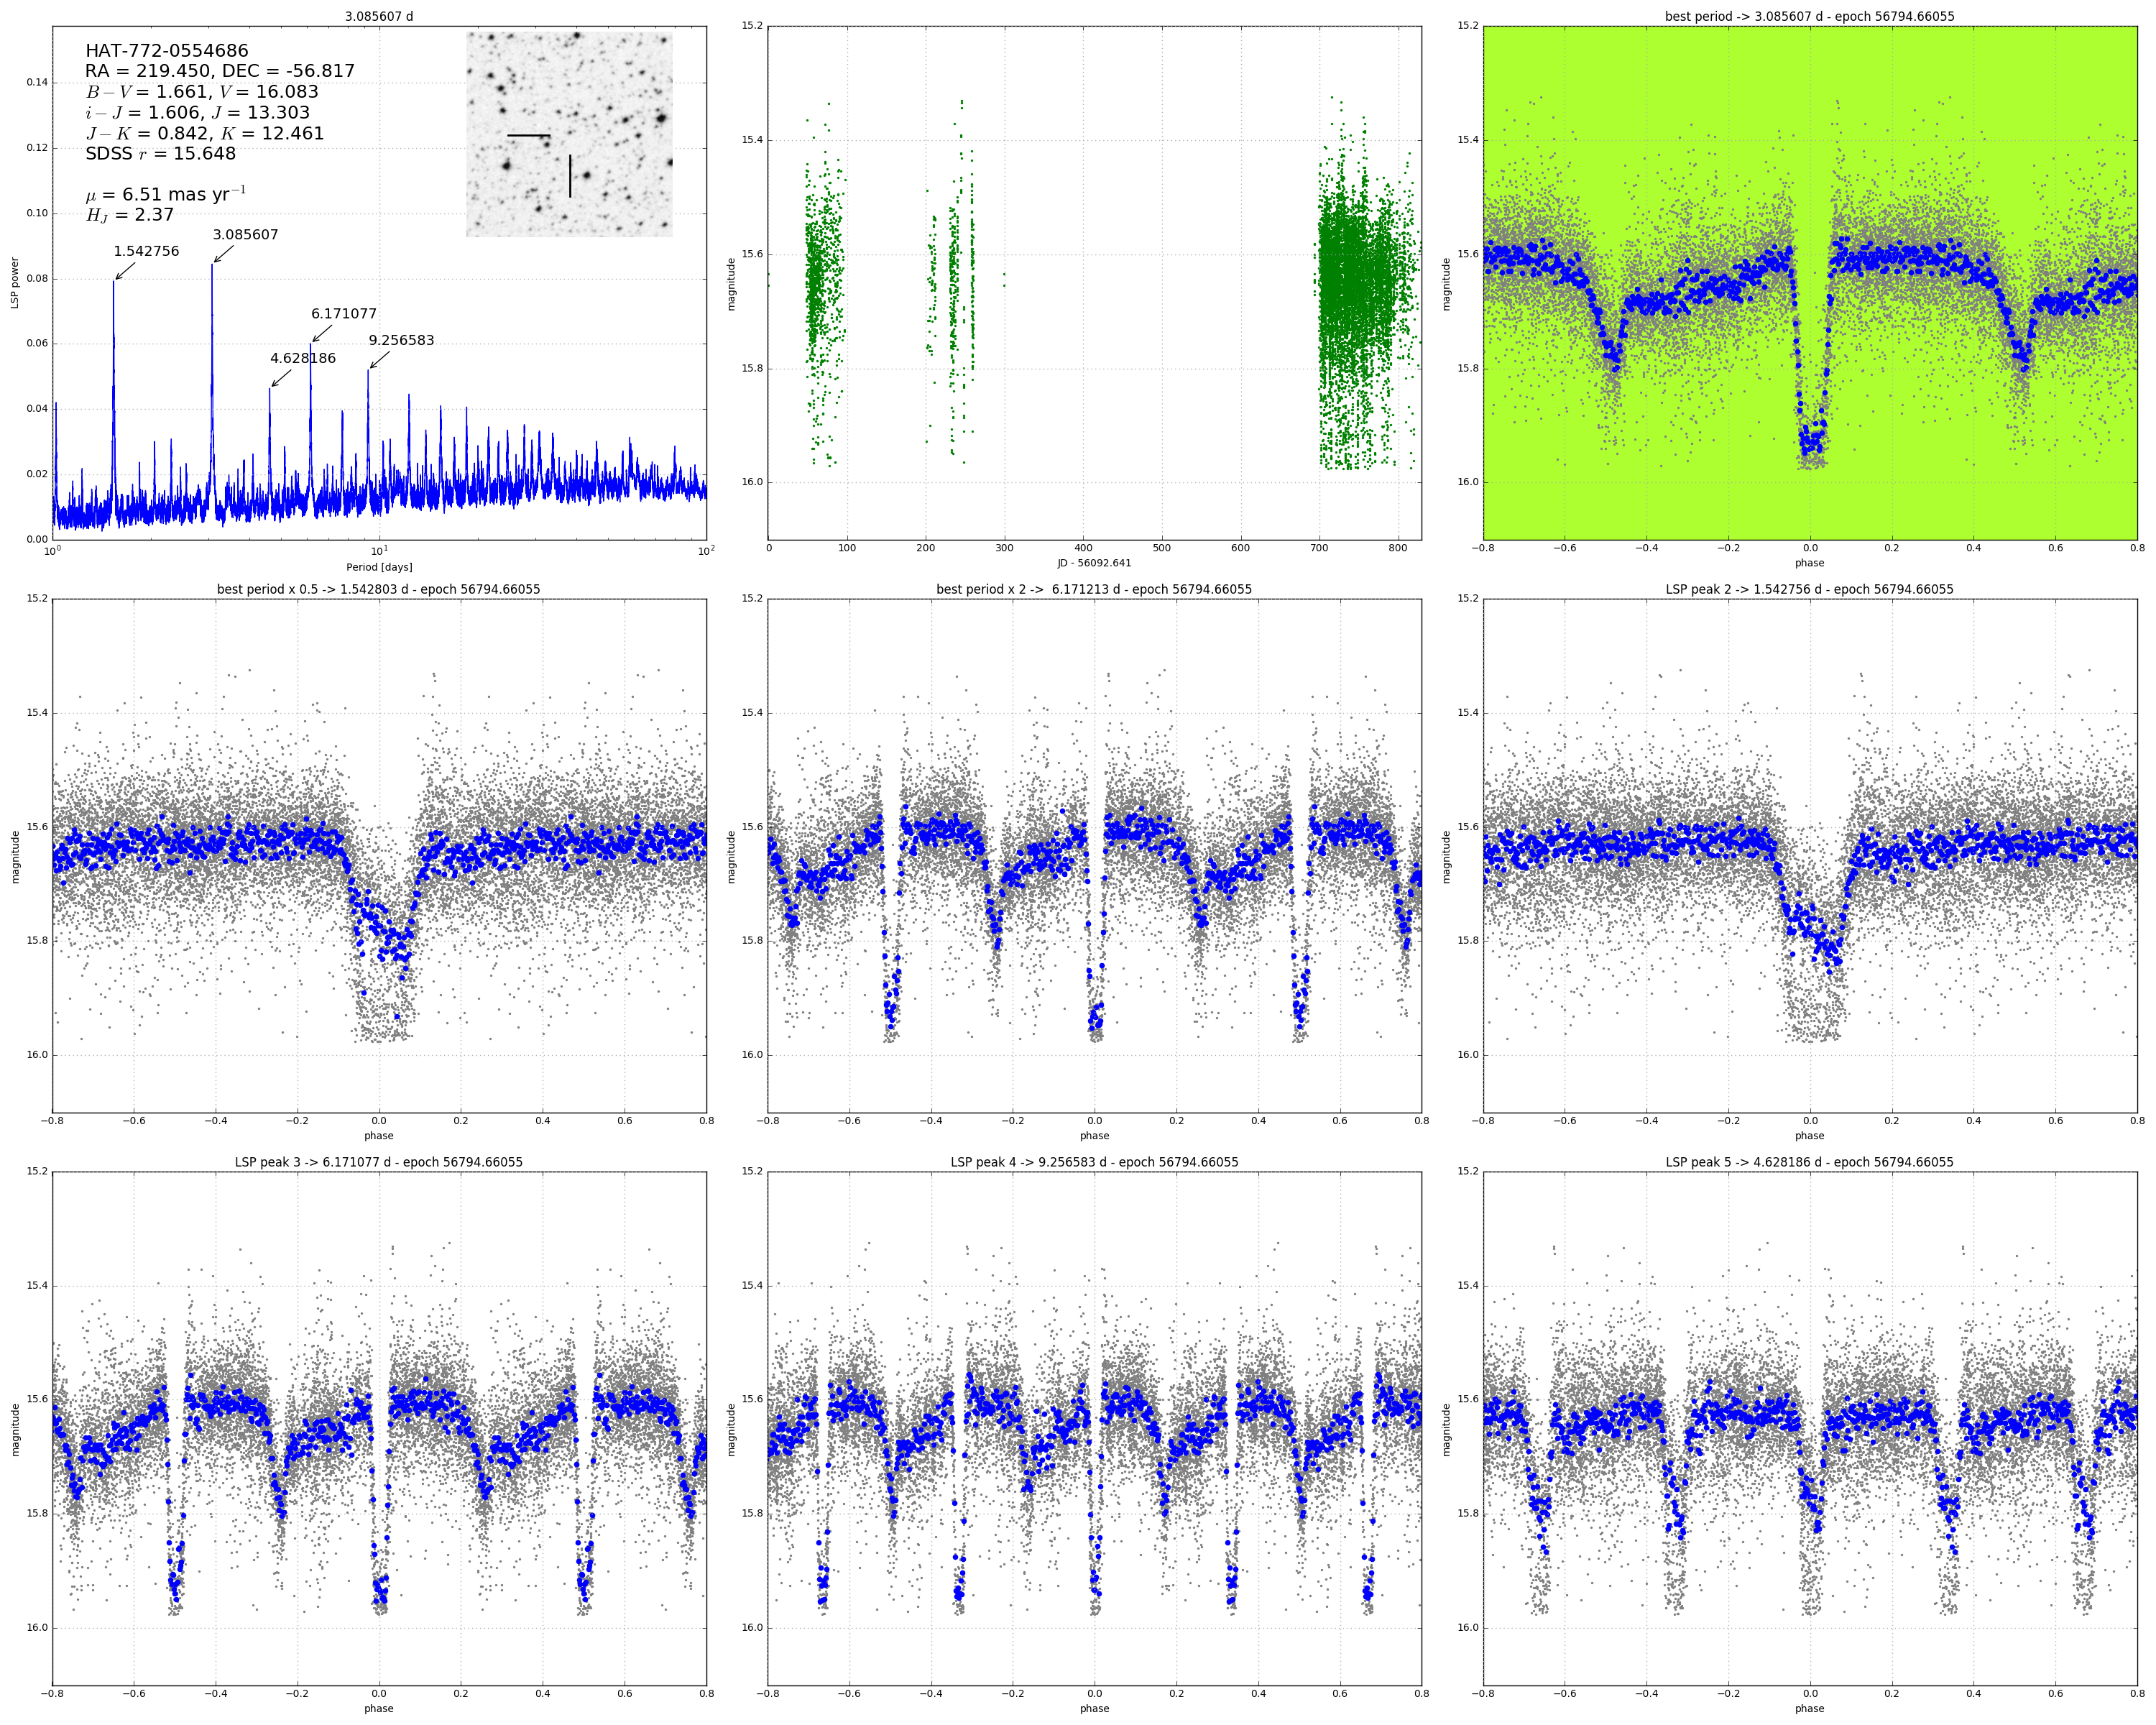

In [14]:
# make another checkplot
cp = plotbase.make_checkplot(blsp, times, mags, errs, objectinfo=normlcd['objectinfo'])
Image('checkplot.png')